## Solucion del problemas de las N-reinas usando algoritmos geneticos

### Desarollado por 
Vilca Daza Diego Percy

#### Instalacion de python-chess para mostrar las soluciones de forma grafica

In [1]:
!pip install python-chess

#### Importacion de librerias

In [2]:
# para renderizar los svg
from  IPython.display  import display
# libreria de ajedrez
import chess
# libreria que exporte el tablero en formato svg
import chess.svg
import random
import math

In [14]:
# funcion generadora de muestras
#   n_sample: cantidad que debe tener la muestra
#   n_queens: numero de reinas (columnas) que tendra el tablero de ajedrez
def generate_sample(n_sample, n_queens):
    sample = []
    for _ in range(n_sample):
        sample.append([int(random.random()*n_queens) for i in range(n_queens)])
    return sample

In [4]:
# funcion fitness para brindar un score a cada candidato (tablero), el score se basa en el numero de reinas atacadas por cada ficha acumulada
#   chromosome: estado del tablero
def fitness(chromosome):
    score = 0
    # calculo acumulado de reinas atacadas
    for gen_col, gen_row in enumerate(chromosome):
        q_attacked = 0
        # calculo de reinas atacadas por la ficha (gen_col, gen_row)
        for column, row in enumerate(chromosome):
            if gen_col == column:
                continue
            x = gen_col - column
            y = gen_row - row
            if row == gen_row:
                q_attacked += 1
            elif x**2 == y**2:
                q_attacked += 1
        # score += reinas atacadas por la ficha (gen_col, gen_row)
        score += q_attacked
    # debido a que se utilizara la seleccion por rueda de ruleta
    # se resta la cantidad acumulada de reinas acumuladas en el peor escenario donde todos se atacan entre si, e.g, todas
    # las fichas se encuentren en una fila o en la linea diagonal del tablero
    # con el score obtenido del escenario que se esta evaluando
    # Esto hara que la solucion con menos numero de reinas atacadas tenga mas cantidad de "tickets" o posibilidades de ser
    # seleccionado en la ruleta
    # por ende, si la solucion tiene como score el valor de 0 (ninguna reina atacada acumulada), su numero de tickets o 
    # score final sera de 56 (en el caso que se tenga 8 reinas)
    final_score = (7 * len(chromosome)) - score
    return final_score

In [5]:
def roulette_wheel(sample):
    n = len(sample)
    # calcula del fitness individual por cada cromosoma
    arr_fit = [(chromosome,fitness(chromosome)) for chromosome in sample]
    # fitness acumulado 
    accum = sum(i[1] for i in arr_fit)
    # calculo de la probabilidad por cada cromosoma segun su valor de fitness
    prob = [(tupl[0],tupl[1]/accum) for tupl in arr_fit]
    # ordenacion de menor a mayor de la lista de probabilidades 
    prob.sort(key=lambda x:x[1])
    
    roulette = []
    # para fines practicos, se elabora un array donde cada elemento tendra la siguiente representacion
    # por cada par de items de la lista se tiene
    # [..., (cromosoma0, floor0), (cromosoma1, floor1), ...]
    # region donde el cromosoma se encuentra, en base al rango [0,1>
    # 0 <= ... <= floor0 <= prob_de_seleccion(cromosoma1) < floor1 < ... < 1
    # En caso que el valor aleatorio se encuentre entre floor0 y floor1, se seleccionara al cromosoma1 como escogido para
    # el cruce
    for idx, item in enumerate(prob):
        if idx == 0:
            roulette.append((item[0],item[1]))
        else:
            roulette.append((item[0], roulette[idx-1][1] + item[1]))
    new_sample = []
    for i in range(n//2):
        # calculo del valor aleatorio
        dice_score = random.random()
        for item in roulette:
            # evaluacion mediante un bucle de floor0 < cromosoma1 < floor1
            if dice_score < item[1]:
                new_sample.append(item[0])
                new_sample.append(item[0])
                break
    return new_sample    

In [6]:
# funcion de crossover con un punto fijo
def crossover(sample, point=2):
    n = len(sample)
    competitors_1 = random.sample([i for i in range(n)], n//2)
    competitors_2 = [i for i in range(n) if i not in competitors_1]
    random.shuffle(competitors_2)

    new_sample = []
    for comp1, comp2 in zip(competitors_1, competitors_2):
        child_1 = sample[comp1][:point] + sample[comp2][point:]
        child_2 = sample[comp2][:point] + sample[comp1][point:]
        new_sample.append(child_1)
        new_sample.append(child_2)
    return new_sample

In [7]:
# funcion de crossover con un punto de cruce aleatorio
def crossover_prob_point(sample):
      n = len(sample)
      competitors_1 = random.sample([i for i in range(n)], n//2)
      competitors_2 = [i for i in range(n) if i not in competitors_1]
      random.shuffle(competitors_2)

      new_sample = []
      for comp1, comp2 in zip(competitors_1, competitors_2):
        point = random.randrange(1,len(sample[comp1])-1)
        child_1 = sample[comp1][:point] + sample[comp2][point:]
        child_2 = sample[comp2][:point] + sample[comp1][point:]
        new_sample.append(child_1)
        new_sample.append(child_2)
      return new_sample

In [8]:
# funcion de crossover con un punto de cruce aleatorio con probabilidad de cruce aleatorio
def crossover_prob(sample, pc=0.75):
  n = len(sample)
  # si hay 6 individuos en la muestra, escogemos 3 pares aleatoriamente (seleccionamos los indices)
  competitors_1 = random.sample([i for i in range(n)], n//2)
  competitors_2 = [i for i in range(n) if i not in competitors_1]
  random.shuffle(competitors_2)

  new_sample = []
  for comp1, comp2 in zip(competitors_1, competitors_2):
    if random.random() < pc: #Probabilidad de cruce (suele ser un valor alto)
      point = random.randrange(1,len(sample[comp1])-1)
      child_1 = sample[comp1][:point] + sample[comp2][point:]
      child_2 = sample[comp2][:point] + sample[comp1][point:]
    else:
      child_1 = sample[comp1]
      child_2 = sample[comp2]
    new_sample.append(child_1)
    new_sample.append(child_2)
  return new_sample

In [9]:
# funcion de mutacion
def mutate(sample, pm=0.1):
    new_sample = []
    for chromosome in sample:
        for idx, gen in enumerate(chromosome):
            if random.random() < pm:
                chromosome[idx] = queens - gen -1
        new_sample.append(chromosome)
    return new_sample

In [10]:
import math
def run(sample, n_generation):
    solutions= set()
    idon = len(sample[0]) * 7
    for i in range(n_generation):
        # ejecucion de las funciones
        sample = roulette_wheel(sample)
        # utilizacion de la funcion con punto de cruce aleatorio, debido a que 
        # se obtiene mejores resultados
        sample = crossover_prob_point(sample)
        sample = mutate(sample, 0.1)
        # como el calculo del score es el complemento en base al numero de reinas atacadas
        # se toma el valor maximo de las soluciones, debido a que esto representa que tienen el menor numero de reinas
        # atacadas
        maximum = max([(chromosome, fitness(chromosome)) for chromosome in sample], key=lambda item:item[1])
        if maximum[1] == idon:
            print("Solucion de la generacion", i , "\t", maximum)
            solutions.add(tuple(maximum[0]))
    print("Ejecucion terminada")
    return solutions;

## Ejecucion

In [11]:
queens=8
while True:
    sample = generate_sample(1500,queens)
    solutions = run(sample, 100)
    if len(solutions) == 0:
        print('No se encontro alguna solucion, reiniciando la busqueda')
    else:
        break

Solucion de la generacion 48 	 ([3, 1, 6, 2, 5, 7, 0, 4], 56)
Solucion de la generacion 59 	 ([3, 1, 6, 2, 5, 7, 0, 4], 56)
Solucion de la generacion 68 	 ([5, 2, 6, 1, 7, 4, 0, 3], 56)
Solucion de la generacion 76 	 ([3, 1, 6, 2, 5, 7, 0, 4], 56)
Solucion de la generacion 85 	 ([3, 1, 6, 2, 5, 7, 0, 4], 56)
Solucion de la generacion 88 	 ([4, 6, 1, 5, 2, 0, 7, 3], 56)
Solucion de la generacion 89 	 ([3, 1, 6, 2, 5, 7, 0, 4], 56)
Solucion de la generacion 90 	 ([4, 6, 1, 5, 2, 0, 7, 3], 56)
Solucion de la generacion 91 	 ([4, 6, 1, 5, 2, 0, 7, 3], 56)
Solucion de la generacion 92 	 ([3, 1, 6, 2, 5, 7, 0, 4], 56)
Solucion de la generacion 93 	 ([4, 6, 1, 5, 2, 0, 7, 3], 56)
Solucion de la generacion 94 	 ([4, 6, 1, 5, 2, 0, 7, 3], 56)
Solucion de la generacion 96 	 ([3, 1, 6, 2, 5, 7, 0, 4], 56)
Ejecucion terminada


In [12]:
# impresion de las solucion en la consola de jupyter
solutions

{(3, 1, 6, 2, 5, 7, 0, 4), (4, 6, 1, 5, 2, 0, 7, 3), (5, 2, 6, 1, 7, 4, 0, 3)}

### Impresion de las solucion con la libreria chess-python

SVG


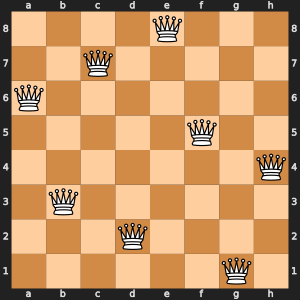

ASCII:
. . . . Q . . .
. . Q . . . . .
Q . . . . . . .
. . . . . Q . .
. . . . . . . Q
. Q . . . . . .
. . . Q . . . .
. . . . . . Q .
SVG


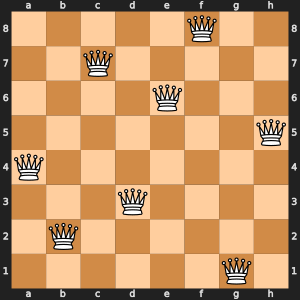

ASCII:
. . . . . Q . .
. . Q . . . . .
. . . . Q . . .
. . . . . . . Q
Q . . . . . . .
. . . Q . . . .
. Q . . . . . .
. . . . . . Q .
SVG


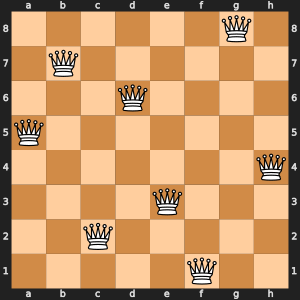

ASCII:
. . . . . . Q .
. Q . . . . . .
. . . Q . . . .
Q . . . . . . .
. . . . . . . Q
. . . . Q . . .
. . Q . . . . .
. . . . . Q . .


In [13]:
from IPython.display import HTML
# creacion del tablero
board = chess.Board()
if len(solutions) > 0:
    # iteracion por cada solucion
    for solution in solutions:
        # limpieza del tablero, debido a que por default se tiene todas las fichas utilizadas
        # para un partida normal de ajedrez
        board.clear_board() 
        # utilizacion del objeto reina
        piece = chess.Piece(chess.QUEEN, chess.WHITE)
        # asignacion de las posiciones de las reinas
        for column, row in enumerate(solution):
            # creacion del objeto de locacion
            square = chess.square(column,row)
            # asignacion de la pieza en la locacion
            board.set_piece_at(square, piece)
        # renderizar svg de la solucion
        print("SVG")
        display(chess.svg.board(board, size=300))
        print("ASCII:")
        print(board)
else:
    print("No solutions")